In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.utils import shuffle
from scipy import stats


In [2]:
data = pd.read_csv('/Users/_fangkhai/Documents/Computer Science Semester 5/Introduction to Data Science/Assignment Dataset/INFY Historical Data (2009-2019).csv').fillna(0)
data["Date"] = pd.to_datetime(data.Date)
data.set_index ("Date", inplace = True)
data.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [3]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,731.15,729.70,737.75,725.45,6.93M,-0.24%
2019-12-30,732.90,736.10,737.95,727.25,5.37M,-0.55%
2019-12-27,736.95,729.75,737.50,728.85,3.40M,1.10%
2019-12-26,728.95,732.00,734.55,726.55,3.82M,-0.61%
2019-12-24,733.40,736.95,736.95,728.30,2.89M,-0.35%
...,...,...,...,...,...,...
2009-01-07,147.28,145.25,148.52,142.08,22.54M,1.63%
2009-01-06,144.92,146.34,147.58,142.05,11.56M,-0.36%
2009-01-05,145.45,141.38,146.93,141.35,11.24M,3.60%


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2721 entries, 2019-12-31 to 2009-01-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     2721 non-null   float64
 1   Open      2721 non-null   float64
 2   High      2721 non-null   float64
 3   Low       2721 non-null   float64
 4   Vol.      2721 non-null   object 
 5   Change %  2721 non-null   object 
dtypes: float64(4), object(2)
memory usage: 148.8+ KB


In [5]:
data["Vol."] = data["Vol."].str.replace("M", "")
data["Change %"] = data["Change %"].str.replace("%", "")

In [6]:
data['Vol.'] = pd.to_numeric(data['Vol.'], errors='coerce')
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

In [7]:
data.isnull().sum()

Price        0
Open         0
High         0
Low          0
Vol.        17
Change %     0
dtype: int64

In [8]:
data.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

In [9]:
data = data.fillna(data["Vol."].mean())

In [10]:
data.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [11]:
z = np.abs(stats.zscore(data))
z

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,1.863632,1.851267,1.857495,1.874146,0.287020,0.180120
2019-12-30,1.875259,1.893724,1.858811,1.886207,0.474970,0.356297
2019-12-27,1.902167,1.851598,1.855850,1.896928,0.712317,0.581419
2019-12-26,1.849016,1.866525,1.836439,1.881517,0.661715,0.390396
2019-12-24,1.878581,1.899363,1.852231,1.893243,0.773762,0.242635
...,...,...,...,...,...,...
2009-01-07,2.015579,2.025946,2.019563,2.034763,1.593686,0.882625
2009-01-06,2.031259,2.018715,2.025748,2.034964,0.270807,0.248318
2009-01-05,2.027738,2.051619,2.030025,2.039655,0.232253,2.002201


In [12]:
(np.abs(stats.zscore(data)) > 3).sum()

Price        0
Open         0
High         0
Low          0
Vol.        38
Change %    30
dtype: int64

In [13]:
data_clean = data[((np.abs(stats.zscore(data)))<3).all(axis=1)]
data_clean

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-12-31,731.15,729.70,737.75,725.45,6.93,-0.24
2019-12-30,732.90,736.10,737.95,727.25,5.37,-0.55
2019-12-27,736.95,729.75,737.50,728.85,3.40,1.10
2019-12-26,728.95,732.00,734.55,726.55,3.82,-0.61
2019-12-24,733.40,736.95,736.95,728.30,2.89,-0.35
...,...,...,...,...,...,...
2009-01-07,147.28,145.25,148.52,142.08,22.54,1.63
2009-01-06,144.92,146.34,147.58,142.05,11.56,-0.36
2009-01-05,145.45,141.38,146.93,141.35,11.24,3.60


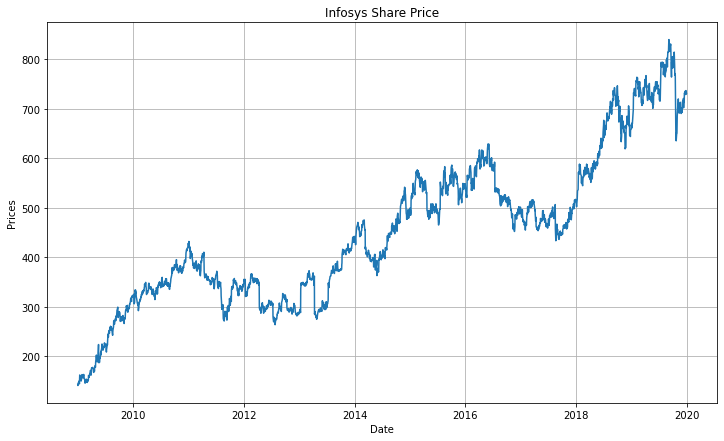

In [14]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.plot(data["Price"])
plt.title("Infosys Share Price")
plt.show()

<AxesSubplot:ylabel='Density'>

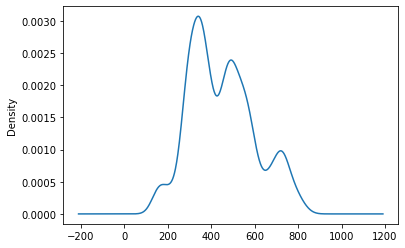

In [15]:
df = data["Price"]
df.plot(kind = "kde")

### Determine MA (Parameter q)

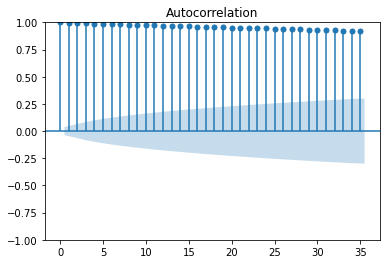

In [16]:
plot_acf(data["Price"], lags = 35)
plt.show()

### Determine AR (Parameter p)

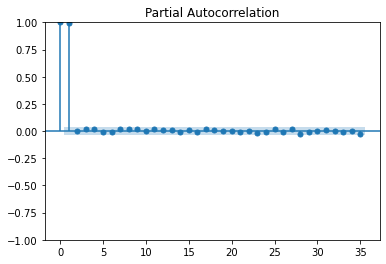

In [17]:
plot_pacf(data["Price"], lags = 35)
plt.show()

### SelectKBest

In [18]:
open_price_crosstab = pd.crosstab(data["Open"], data["Price"], margins = True)
open_price_crosstab

Price,140.4,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Open,,,,,,,,,,,,,,,,,,,,,
138.41,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
141.38,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
142.83,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
143.24,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
144.48,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
832.05,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
836.8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [19]:
high_price_crosstab = pd.crosstab(data["High"], data["Price"], margins = True)
high_price_crosstab

Price,140.4,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
High,,,,,,,,,,,,,,,,,,,,,
142.98,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
144.48,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
146.93,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
147.34,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
147.58,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
837.95,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
840.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [20]:
low_price_crosstab = pd.crosstab(data["Low"], data["Price"], margins = True)
low_price_crosstab

Price,140.4,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Low,,,,,,,,,,,,,,,,,,,,,
137.88,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
138.33,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
138.78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
139.37,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
141.17,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
826.65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
827.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [21]:
vol_price_crosstab = pd.crosstab(data["Vol."], data["Price"], margins = True)
vol_price_crosstab

Price,140.4,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Vol.,,,,,,,,,,,,,,,,,,,,,
1.09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
164.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
change_price_crosstab = pd.crosstab(data["Change %"], data["Price"], margins = True)
change_price_crosstab

Price,140.4,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.7,821.3,827.7,829.1,829.3,829.85,831.25,834.05,840.15,All
Change %,,,,,,,,,,,,,,,,,,,,,
-21.26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-16.19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-13.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-12.66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-9.58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11.13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13.02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
shuffled_data = shuffle(data, random_state = 700)

#X = Independent Variable
target_col = "Price"
X = data.drop("Price", axis = 1)

#y = Dependent Variable
y = shuffled_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 700)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2176, 5) (545, 5) (2176,) (545,)


In [24]:
X_n = SelectKBest(f_classif, k = 1).fit_transform(X, y)
X_n.shape

#Another method (Giving Same Results)

X_new = SelectKBest(f_classif, k = 1).fit(X_train, y_train)
X_train.columns[X_new.get_support()]

Index(['Low'], dtype='object')

In [25]:
pd.crosstab(np.squeeze(X_n), np.squeeze(y))

Price,140.40,142.39,143.83,144.92,145.45,145.59,145.99,146.19,146.58,147.03,...,820.10,820.70,821.30,827.70,829.10,829.30,829.85,831.25,834.05,840.15
row_0,,,,,,,,,,,,,,,,,,,,,
137.88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138.33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138.78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139.37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141.17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
824.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
826.65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


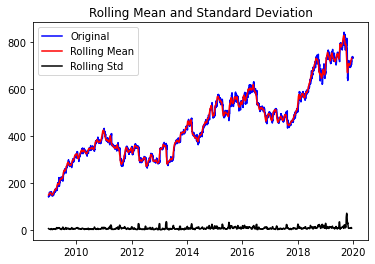

Results of dickey fuller test
Test Statistics                  -1.187057
p-value                           0.679139
No. of lags used                  2.000000
Number of observations used    2718.000000
critical value (1%)              -3.432758
critical value (5%)              -2.862604
critical value (10%)             -2.567336
dtype: float64


In [26]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform dickey fuller test
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(data["Price"])

### Transform To Stationary

<Figure size 432x288 with 0 Axes>

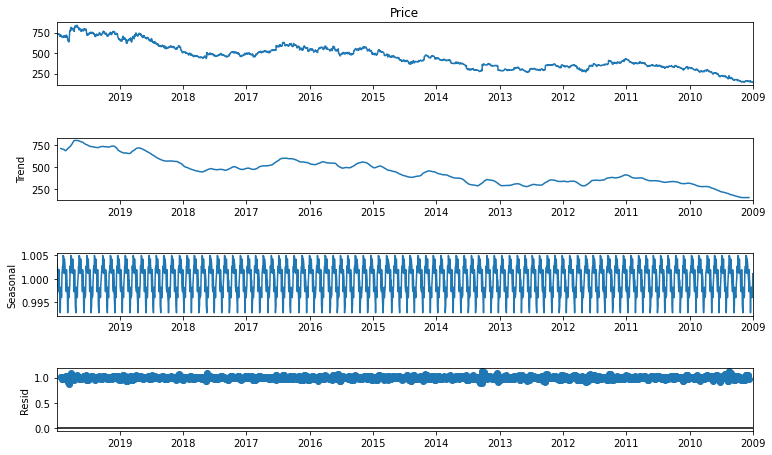

In [27]:
result = seasonal_decompose(df, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 7)

No handles with labels found to put in legend.


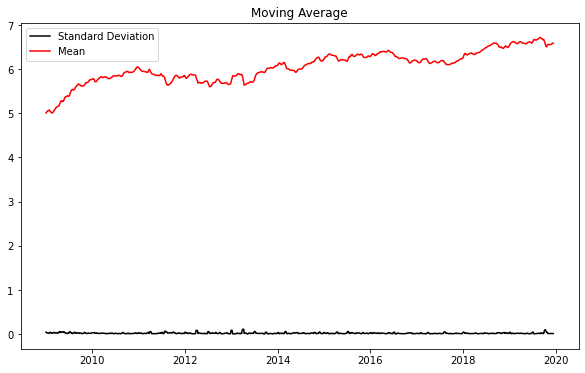

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

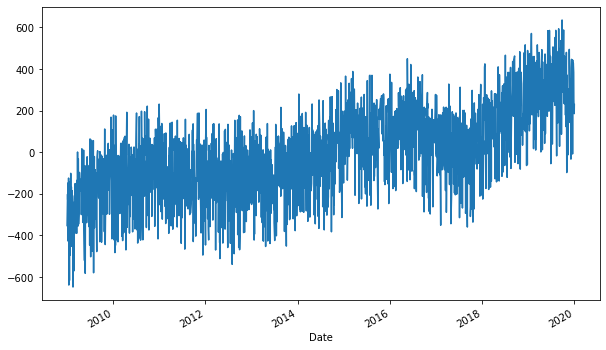

In [29]:
y_train_diff = y_train.diff().dropna()
y_train_diff.plot()

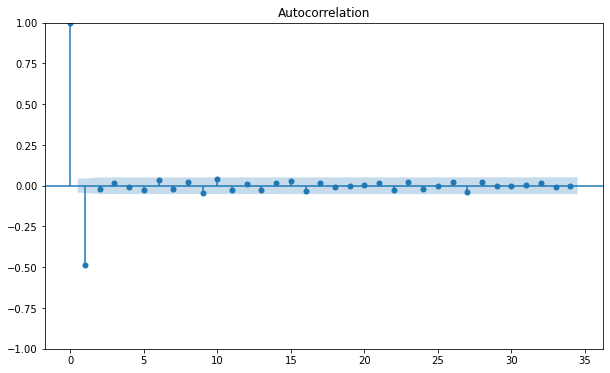

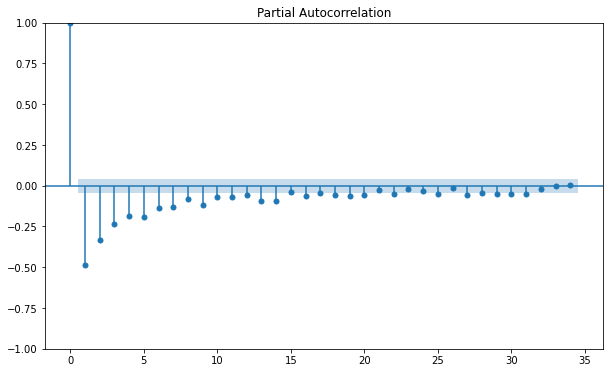

In [30]:
acf_diff = plot_acf(y_train_diff)

pacf_diff = plot_pacf(y_train_diff)

In [31]:
adf_test = adfuller(y_train_diff)
print(f'p-value: {adf_test[1]}')


p-value: 3.1822661394807967e-28


In [32]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [33]:
stepwise_fit = auto_arima(data["Low"], trace=True, suppress_warning=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18676.082, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18678.984, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18678.165, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18678.034, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18679.244, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18674.081, Time=0.68 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18678.765, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18679.178, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18676.081, Time=1.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18679.437, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18674.092, Time=1.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18677.577, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18675.424, Time=0.32 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 7.050 seconds
         

In [34]:
#For 10 Years
model = sm.tsa.arima.ARIMA(data["Low"], order = (1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/_fangkhai/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  

                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                 2721
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9333.712
Date:                Fri, 21 Apr 2023   AIC                          18675.424
Time:                        15:34:44   BIC                          18699.058
Sample:                             0   HQIC                         18683.968
                               - 2721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8658      0.081     10.687      0.000       0.707       1.025
ma.L1         -0.8345      0.083    -10.089      0.000      -0.997      -0.672
ma.L2         -0.0527      0.013     -4.213      0.0

### Predict

In [35]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)
predictions

Date
2011-03-15    374.883601
2011-03-14    372.725699
2011-03-11    376.003619
2011-03-10    377.650407
2011-03-09    379.800395
                 ...    
2009-01-07    145.447909
2009-01-06    142.092129
2009-01-05    142.236671
2009-01-02    141.486077
2009-01-01    139.468284
Name: predicted_mean, Length: 545, dtype: float64

In [36]:
s = pd.Series(predictions, index = data.index[-150:]) 
s

Date
2009-08-13    251.772955
2009-08-12    252.715234
2009-08-11    247.452506
2009-08-10    255.856150
2009-08-07    254.156313
                 ...    
2009-01-07    145.447909
2009-01-06    142.092129
2009-01-05    142.236671
2009-01-02    141.486077
2009-01-01    139.468284
Name: predicted_mean, Length: 150, dtype: float64

<AxesSubplot:xlabel='Date'>

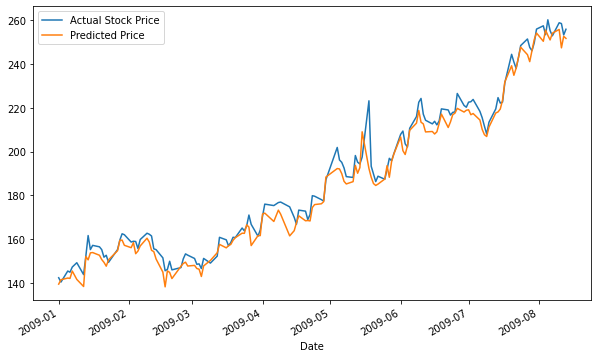

In [37]:
data["Price"][-150:].plot(label = "Actual Stock Price", legend = True)
s.plot(label = "Predicted Price", legend = True)

In [38]:
mape = np.mean(np.abs((test["Price"] - predictions) / test["Price"])) * 100
mape

1.3824412972778934

In [39]:
mae = mean_absolute_error(test["Price"], predictions)
mae

3.862040943935004

In [40]:
mse = mean_squared_error(test["Price"], predictions)
mse

25.968461809252496

In [41]:
rmse = math.sqrt(mse)
rmse

5.095926001155481